# Preparing Data

<br>

## 1- reading and exploring data

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import warnings

warnings.filterwarnings("ignore")

In [4]:
print(os.listdir('digit-recognizer data/'))

['sample_submission.csv', 'test.csv', 'train.csv']


In [6]:
train = pd.read_csv('digit-recognizer data/train.csv')
test = pd.read_csv('digit-recognizer data/test.csv')
submission = pd.read_csv('digit-recognizer data/sample_submission.csv')

print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [7]:
# put labels into y_train variable
y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

X_train.shape, y_train.shape

((42000, 784), (42000,))

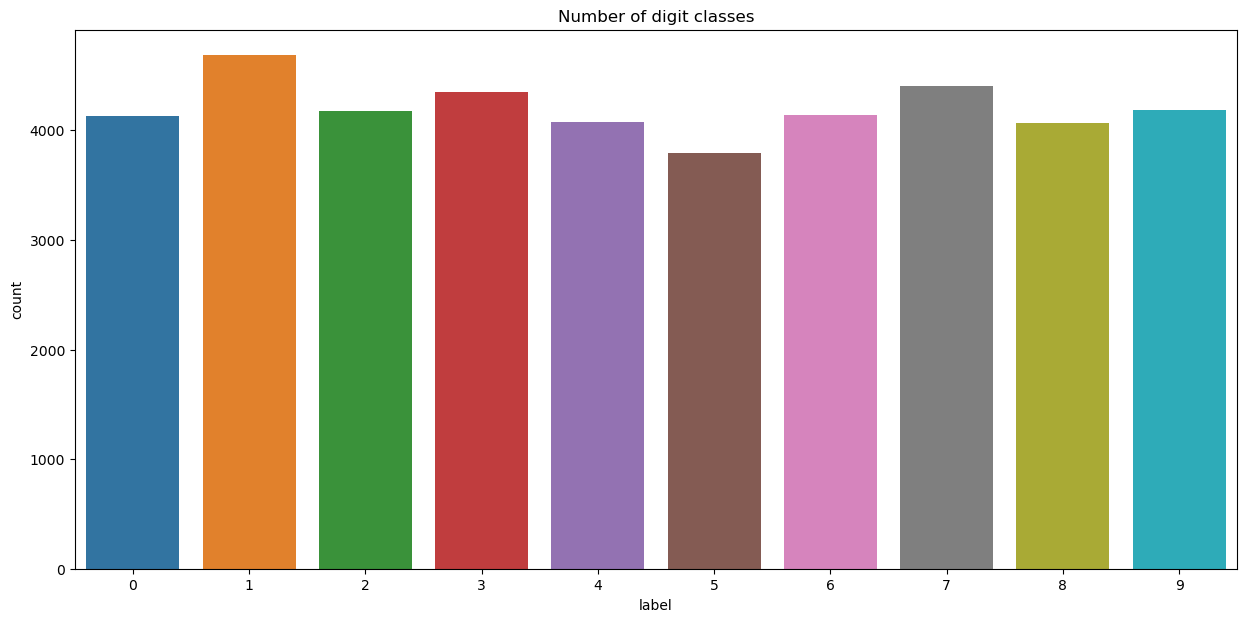

In [5]:
# visualize number of digits classes

plt.figure(figsize=(15,7))
sns.countplot(y_train)
plt.title("Number of digit classes");

#### All classes are almost balanced

## 2- Ploting a sample

**Note that** we choose the shapeof images `28 x 28` becouse the dataframe contains 784 which means `28 x 28`.

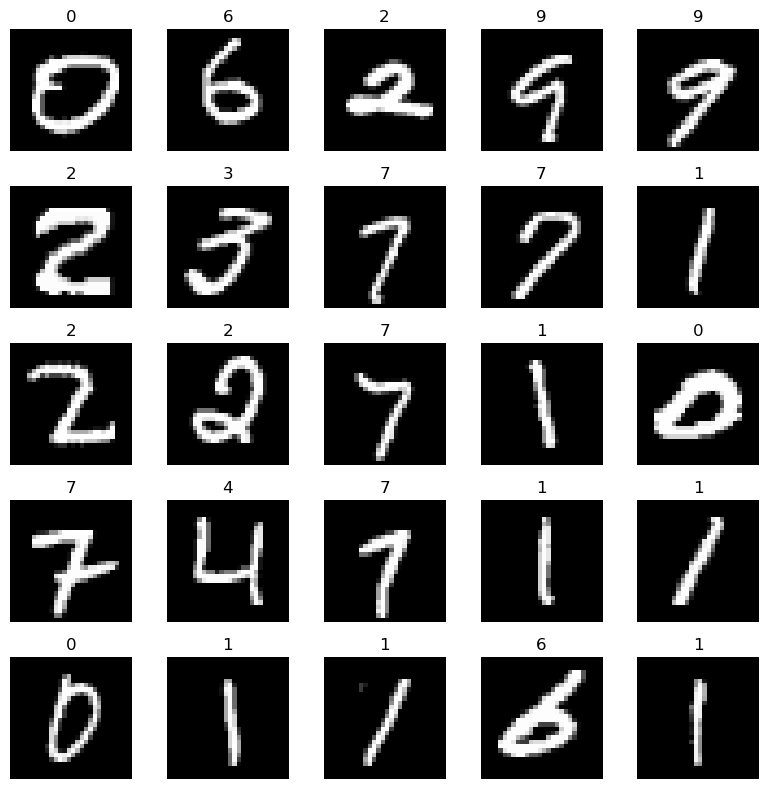

In [6]:
np.random.seed(42)
random_indices = np.random.randint(0, 42000, 25)

images=[]
labels=[]
for i in random_indices:
    img = X_train.iloc[i].to_numpy()
    img = img.reshape((28,28,1))
    images.append(img)
    label = y_train[i]
    labels.append(label)
    
# Plot the images
plt.subplots(figsize = (8, 8))
for i, image in enumerate(images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(labels[i])
    plt.axis('off')


plt.tight_layout()
plt.show()

## 3- Normalization, Reshape and Label Encoding 
* Normalization
    * We perform a grayscale normalization to reduce the effect of illumination's differences.
    * If we perform normalization, CNN works faster.
* Reshape
    * Train and test images (28 x 28) 
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel. 
* Label Encoding  
    * Encode labels to one hot vectors 
        * 2 => [0,0,1,0,0,0,0,0,0,0]
        * 4 => [0,0,0,0,1,0,0,0,0,0]

In [8]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# Label Encoding 
y_train = to_categorical(y_train, num_classes = 10)

# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


## 4- Spliting the data

We split the data into train and val sets.
* val size is 20%.
* train size is 80%.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(33600, 28, 28, 1) (33600, 10)
(8400, 28, 28, 1) (8400, 10)


# Data Augmentation 

To avoid overfitting problem.


In [10]:
datagen = ImageDataGenerator(
    
        featurewise_center = False,  
        samplewise_center = False,  
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,  
    
        rotation_range = 20,  
        zoom_range = 0.2, 
        width_shift_range = 0.2,  
        height_shift_range = 0.2,  
    
        horizontal_flip = False,  
        vertical_flip = False)  

train_gen = datagen.flow(X_train, y_train, batch_size=128)
val_gen = datagen.flow(X_val, y_val, batch_size=128)

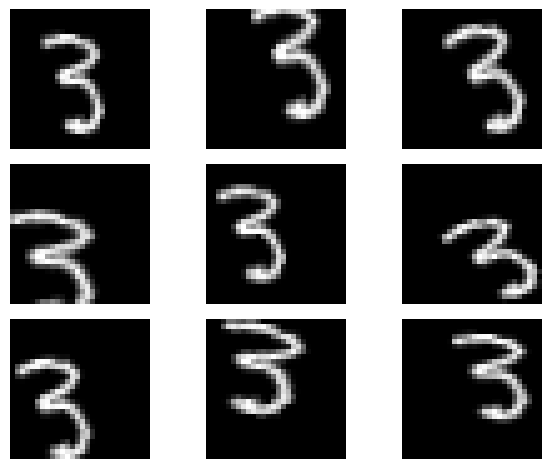

In [11]:
img = X_train[2].reshape((1, 28, 28, 1))

for i, batch in enumerate (datagen.flow(img, batch_size = 1)):
  
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[0], cmap='gray')
    plt.axis('off')
    
    if i == 8: break

# Show the plot
plt.tight_layout()
plt.show()

# modeling

In [16]:
def model():
    model = Sequential([
        
    Conv2D(64, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    Conv2D(64, kernel_size = (3,3), padding = 'Same', activation ='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
        
    Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu'),
    Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Conv2D(filters=256, kernel_size = (3,3), activation="relu"),
    MaxPooling2D(2,2),
    BatchNormalization(),
        
    Flatten(),
    Dense(512, activation = "relu"),
    Dropout(0.5),

    Dense(10, activation = "softmax"),
    ])

    return model

model_1 = model()
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)      

In [17]:
optimizer = Adam(learning_rate=0.001)

model_1.compile(optimizer= optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    patience=5, 
    verbose=1,
    mode="max", 
    restore_best_weights=True)

In [19]:
# Fit the model
history = model_1.fit_generator(
    train_gen, epochs = 20,
    steps_per_epoch = X_train.shape[0] // 128,
    validation_data = val_gen,
    validation_steps = X_val.shape[0] // 128,
    callbacks = [learning_rate_reduction, early_stopping],
    verbose = 2
)

Epoch 1/20
262/262 - 78s - loss: 0.4579 - accuracy: 0.8557 - val_loss: 2.5476 - val_accuracy: 0.1231 - lr: 0.0010 - 78s/epoch - 298ms/step
Epoch 2/20
262/262 - 78s - loss: 0.1478 - accuracy: 0.9542 - val_loss: 0.2773 - val_accuracy: 0.9185 - lr: 0.0010 - 78s/epoch - 298ms/step
Epoch 3/20
262/262 - 78s - loss: 0.1096 - accuracy: 0.9688 - val_loss: 0.1052 - val_accuracy: 0.9674 - lr: 0.0010 - 78s/epoch - 297ms/step
Epoch 4/20
262/262 - 79s - loss: 0.0942 - accuracy: 0.9725 - val_loss: 0.0967 - val_accuracy: 0.9716 - lr: 0.0010 - 79s/epoch - 303ms/step
Epoch 5/20
262/262 - 79s - loss: 0.0791 - accuracy: 0.9766 - val_loss: 0.0740 - val_accuracy: 0.9810 - lr: 0.0010 - 79s/epoch - 303ms/step
Epoch 6/20
262/262 - 84s - loss: 0.0706 - accuracy: 0.9794 - val_loss: 0.0744 - val_accuracy: 0.9784 - lr: 0.0010 - 84s/epoch - 321ms/step
Epoch 7/20
262/262 - 84s - loss: 0.0716 - accuracy: 0.9800 - val_loss: 0.0711 - val_accuracy: 0.9785 - lr: 0.0010 - 84s/epoch - 319ms/step
Epoch 8/20

Epoch 8: Reduce

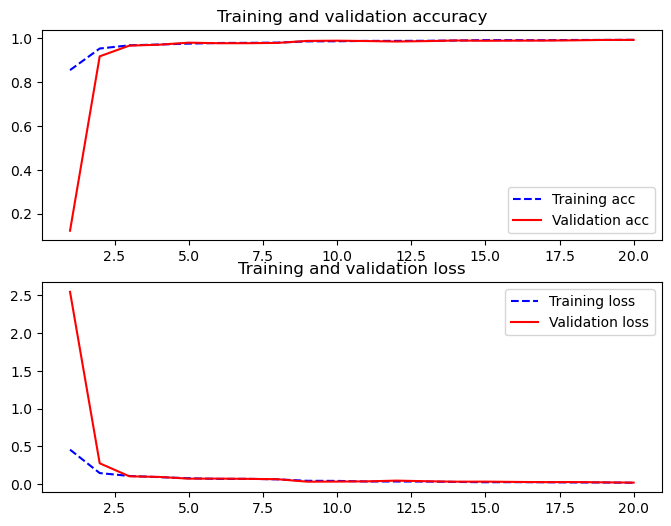

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize = (8, 6))

epochs = range(1, len(acc) + 1)
ax[0].plot(epochs, acc, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [21]:
# Evaluate the model on the training data
train_loss, train_accuracy = model_1.evaluate(X_train, y_train)

# Evaluate the model on the validation data
val_loss, val_accuracy = model_1.evaluate(X_val, y_val)

print('---------------------')
print('Train loss:', round(train_loss,4))
print('Train accuracy:', round(train_accuracy,4))
print('Val loss:', round(val_loss,4))
print('Val accuracy:', round(val_accuracy,4))

263/263 [==============================] - 5s 18ms/step - loss: 0.0197 - accuracy: 0.9939
---------------------
Train loss: 0.0074
Train accuracy: 0.9979
Val loss: 0.0197
Val accuracy: 0.9939


In [22]:
val_predict = model_1.predict(X_val)
val_predict_labels = np.argmax(val_predict, axis = 1)

val_true_labels = np.argmax(y_val, axis = 1)
num_errors = np.count_nonzero(val_predict_labels != val_true_labels)

print(f'Number of error predictions: {num_errors}')

263/263 [==============================] - 5s 18ms/step
Number of error predictions: 51


In [39]:
print(f'the percentage of errors is {(num_errors/len(y_val))}')

the percentage of errors is 0.006071428571428571


# Final Submission

In [23]:
predict_x = model_1.predict(test)  
class_x = np.argmax(predict_x, axis=1)

submission['Label'] = class_x
submission.to_csv('submission1.csv', index= False)

submission.head()

875/875 [==============================] - 16s 19ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


***

<br>

<div style="text-align: center;">
   <span style="font-size: 4.5em; font-weight: bold; font-family: Arial;">THANK YOU!</span>
</div>/

<br>
<br>

<div style="text-align: center;">
    <span style="font-size: 5em;">✔️</span>
</div>

<br>

<div style="text-align: center;">
   <span style="font-size: 1.4em; font-weight: bold; font-family: Arial; max-width:1200px; display: inline-block;">
       If you find this notebook useful, I really would appreciate your upvote!
   </span>
</div>
